
# Relax Data Science Challenge
# Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption. We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')
from pandas import ExcelWriter
from pandas import ExcelFile

In [24]:
#read in csv files
users = pd.read_csv('/Users/venkateshiyersubramanian/Downloads/relax_challenge 2/takehome_users.csv',encoding='latin-1')
engagement = pd.read_csv('/Users/venkateshiyersubramanian/Downloads/relax_challenge 2/takehome_user_engagement.csv',encoding='latin-1')

In [25]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [26]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [27]:
# Only one atribute seems to be having missing values
df = pd.DataFrame(users)
len(df) - df.count()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [28]:
#No missing values!
df_eng =pd.DataFrame(engagement)
len(df_eng) - df_eng.count()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [29]:
#Finding Adopted Users
#convert time stamp to datetime
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)
engagement['week-year'] = engagement['time_stamp'].dt.strftime('%U-%Y')

In [30]:
#group by user and week and aggregate by count
usage = engagement.groupby(['user_id', 'week-year']).size().reset_index().rename(columns={0:'count'})

In [31]:
#if count is greater than or equal to 3, consider user to be an adopted user
usage['adopted'] = usage['count']>=3

In [32]:
#Extract list of adopted users
adopted_users = list(usage[usage.adopted==True].user_id.unique())

In [33]:
#add column in users df to identify adopted users. This is the target variable.
users['adopted'] = users.object_id.apply(lambda x: x in adopted_users).astype(int)

In [34]:
#Setting the object Id as the Index
users_clean = users
users_clean = users_clean.set_index('object_id')

In [35]:
#Dropping name and email as deriving info from this information is not possible
users_clean = users.drop(['name','email'],axis=1)

In [36]:
#Feature Analysis
users_clean.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [37]:
#We need to convert creation source in to numerical values & convert the creation_time and last session creation
#time in to date time

#One-hot encoding of creation_source. Drop first to avoid multicollinearity
cs = pd.get_dummies(users_clean.creation_source,drop_first=True)
df = pd.concat([users_clean,cs],axis=1)

#drop original column
df = df.drop(['creation_source'],axis=1)

In [38]:
df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time,unit='s')

In [39]:
#Extract months from datetime columns.
df['creation_month'] = df.creation_time.dt.month
df['last_session_creation_month'] = df.last_session_creation_time.dt.month

In [40]:
#convert invited by user_id to boolean
df['invited'] = df.invited_by_user_id.notnull().astype(int)

In [41]:
#drop redundant columns that have been converted to features
df = df.drop(['creation_time','last_session_creation_time','invited_by_user_id'],axis=1)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
object_id                      12000 non-null int64
opted_in_to_mailing_list       12000 non-null int64
enabled_for_marketing_drip     12000 non-null int64
org_id                         12000 non-null int64
adopted                        12000 non-null int64
ORG_INVITE                     12000 non-null uint8
PERSONAL_PROJECTS              12000 non-null uint8
SIGNUP                         12000 non-null uint8
SIGNUP_GOOGLE_AUTH             12000 non-null uint8
creation_month                 12000 non-null int64
last_session_creation_month    8823 non-null float64
invited                        12000 non-null int64
dtypes: float64(1), int64(7), uint8(4)
memory usage: 797.0 KB


In [43]:
df['last_session_creation_month'] = df['last_session_creation_month'].fillna(0).astype(int)

In [44]:
#Multicollinearity Check
#Split data into X and y
X = df.drop(['adopted'],axis=1)
y = df['adopted']

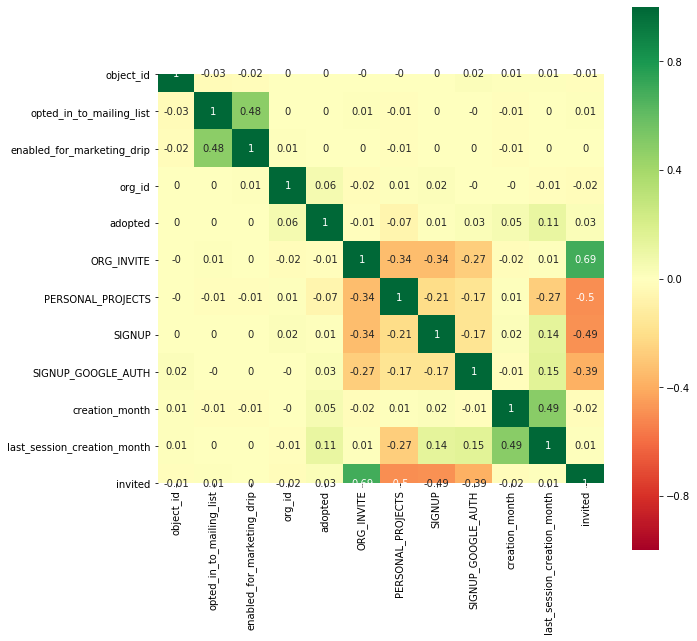

In [46]:
#Correlation matrix
import matplotlib.pyplot as plt
import seaborn

fig, ax = plt.subplots(figsize=(10,10))
_ = sns.heatmap(df.corr().round(2),square=True,annot=True,cmap='RdYlGn',vmin=-1, vmax=1)

In [ ]:
#We can see that the org invite has the highest correlation with personal projects and signup(0.34) Whereas for 
#adopted the highest correlation comes from laast session creation month (0.11)

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Multicollinearity analysis
#Get features
feature_x = X
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
10,7.283148,invited
6,2.520072,SIGNUP
5,2.458673,PERSONAL_PROJECTS
7,2.018070,SIGNUP_GOOGLE_AUTH
4,1.915706,ORG_INVITE


In [ ]:
#Since all the VIFs are less than 10, it doesn't look like we have much multicollinearity present in our data;
#We're good to move forward with our machine learning modelling

In [48]:
#ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
#Split data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [51]:
#Randome Forest

from sklearn.ensemble import RandomForestClassifier

# instantiate model to run 50 estimators
rf = RandomForestClassifier(n_estimators=50, random_state=42)

#Cross-validate on training set
cv_accuracy_rf = cross_val_score(rf, X_train, y_train, cv=5,scoring='f1')

# train model
rf.fit(X_train, y_train)

# predict on test data
y_pred_rf = rf.predict(X_test)

In [52]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_rf))

Train Accuracy: 0.78087
Test Accuracy: 0.95806
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         3116           54
Actual 1           97          333
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3170
           1       0.86      0.77      0.82       430

    accuracy                           0.96      3600
   macro avg       0.92      0.88      0.90      3600
weighted avg       0.96      0.96      0.96      3600



In [54]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

# instantiate model to run 50 estimators
gb = GradientBoostingClassifier(random_state=42)

#Cross-validate on training se=-809\p
cv_accuracy_gb = cross_val_score(gb, X_train, y_train, cv=5,scoring='f1')

# train model
gb.fit(X_train, y_train)

# predict on test data
y_pred_gb = gb.predict(X_test)

In [55]:
print("Train Accuracy:",format(np.mean(cv_accuracy_gb),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_gb),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_gb),
             columns = ['Predicted 0','Predicted 1'],
             index=['Actual 0','Actual 1'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_gb))

Train Accuracy: 0.79515
Test Accuracy: 0.95917
Confusion Matrix: 
          Predicted 0  Predicted 1
Actual 0         3129           41
Actual 1          106          324
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3170
           1       0.89      0.75      0.82       430

    accuracy                           0.96      3600
   macro avg       0.93      0.87      0.90      3600
weighted avg       0.96      0.96      0.96      3600



In [ ]:
#Both Random Forest and Gradient Boosting classifiers provide good training and test accuracies of about 96%.
#The f-1 score is 0.98 for the "not adopted" class and 0.82 for the "adopted class.

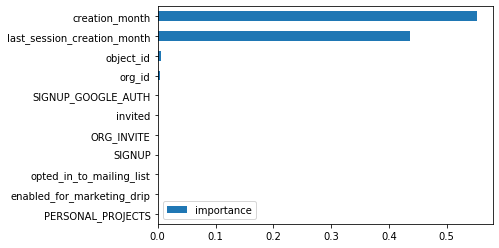

In [56]:
#Feature Importance
feature_importances = pd.DataFrame(gb.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=True)

feature_importances.plot(kind='barh')

In [ ]:
# #Based on the above chart we can see that the creation month and last session creation month are top two leading
# features